In [4]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import torch

No backend selected.
Finding available backend...


2024-12-11 10:05:54.241231: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 10:05:54.546961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733882754.701386 1418974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733882754.747981 1418974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 10:05:55.043542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term


W0000 00:00:1733882758.171624 1418974 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
pip install deepxde


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 736.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install deepxde


Defaulting to user installation because normal site-packages is not writeable


In [5]:
geom = dde.geometry.Rectangle([-1,-1],[1,1])
timedomain = dde.geometry.TimeDomain(0,10)
geomtime = dde.geometry.GeometryXTime(geom,timedomain)

In [6]:
alpha = 0.5
def pde(x,y):
    dy_t = dde.grad.jacobian(y,x,i=0,j=2)
    dy_xx = dde.grad.hessian(y,x,i=0,j=0)
    dy_yy = dde.grad.hessian(y,x,i=1,j=1)
    return dy_t - alpha * (dy_xx + dy_yy)

In [7]:
# 上边界，y=1
def boundary_t(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)

# 下边界，y=-1
def boundary_b(x, on_boundary):
    return on_boundary and np.isclose(x[1], -1)

# 左边界，x=-1
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

# 右边界，x=1
def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)


bc_t = dde.icbc.NeumannBC(geomtime, lambda x:0, boundary_t)
bc_b = dde.icbc.NeumannBC(geomtime, lambda x:20, boundary_b)
bc_l = dde.icbc.DirichletBC(geomtime, lambda x:30, boundary_l)
bc_r = dde.icbc.DirichletBC(geomtime, lambda x:50, boundary_r)

In [8]:
def init_func(x):
    return 0

ic = dde.icbc.IC(geomtime,init_func,lambda _,on_initial:on_initial,)

In [11]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l,bc_r,bc_b,bc_t,ic],
    num_domain=8000,   
    num_boundary=320,   
    num_initial=800,    
    num_test=8000,     
)

layer_size = [3] + [50] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.056796 s

'compile' took 0.605599 s



I0000 00:00:1733882901.294286 1418974 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.79e-03, 8.84e+02, 2.46e+03, 4.12e+02, 7.31e-02, 1.20e-01]    [8.01e-03, 8.84e+02, 2.46e+03, 4.12e+02, 7.31e-02, 1.20e-01]    []  
1000      [3.63e+01, 6.40e+00, 1.00e+02, 2.39e+01, 1.21e+00, 6.88e+00]    [2.85e+01, 6.40e+00, 1.00e+02, 2.39e+01, 1.21e+00, 6.88e+00]    []  
2000      [8.55e+00, 1.37e+00, 3.59e+00, 3.52e+00, 9.49e-01, 8.98e-01]    [6.08e+00, 1.37e+00, 3.59e+00, 3.52e+00, 9.49e-01, 8.98e-01]    []  
3000      [1.51e+00, 5.11e-01, 6.01e-01, 3.25e-01, 4.91e-01, 2.83e-01]    [1.65e+00, 5.11e-01, 6.01e-01, 3.25e-01, 4.91e-01, 2.83e-01]    []  
4000      [6.56e-01, 2.50e-01, 1.86e-01, 9.03e-02, 2.87e-01, 1.29e-01]    [1.31e+00, 2.50e-01, 1.86e-01, 9.03e-02, 2.87e-01, 1.29e-01]    []  
5000      [3.79e-01, 1.49e-01, 1.07e-01, 4.59e-02, 2.31e-01, 6.40e-02]    [1.04e+00, 1.49e-01, 1.07e-01, 4.59e-02, 2

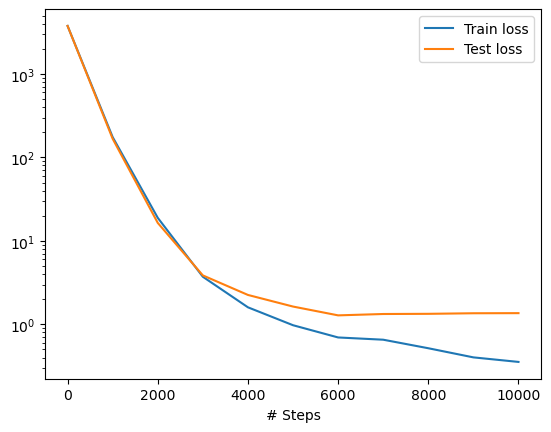

In [12]:
losshistory,train_state = model.train(iterations=10000,display_every=1000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

(40000, 3) (40000, 1)
(40000, 4, 21) (40000, 4)
保存路径: 2DtransientRectTC
data.shape[2] =  21
0 (40000,) (40000,) (40000,)
0 (40000,) (40000,) (40000,)
1 (40000,) (40000,) (40000,)
2 (40000,) (40000,) (40000,)
3 (40000,) (40000,) (40000,)
4 (40000,) (40000,) (40000,)
5 (40000,) (40000,) (40000,)
6 (40000,) (40000,) (40000,)
7 (40000,) (40000,) (40000,)
8 (40000,) (40000,) (40000,)
9 (40000,) (40000,) (40000,)
10 (40000,) (40000,) (40000,)
11 (40000,) (40000,) (40000,)
12 (40000,) (40000,) (40000,)
13 (40000,) (40000,) (40000,)
14 (40000,) (40000,) (40000,)
15 (40000,) (40000,) (40000,)
16 (40000,) (40000,) (40000,)
17 (40000,) (40000,) (40000,)
18 (40000,) (40000,) (40000,)
19 (40000,) (40000,) (40000,)
20 (40000,) (40000,) (40000,)
0 (40000,) (40000,) (40000,)


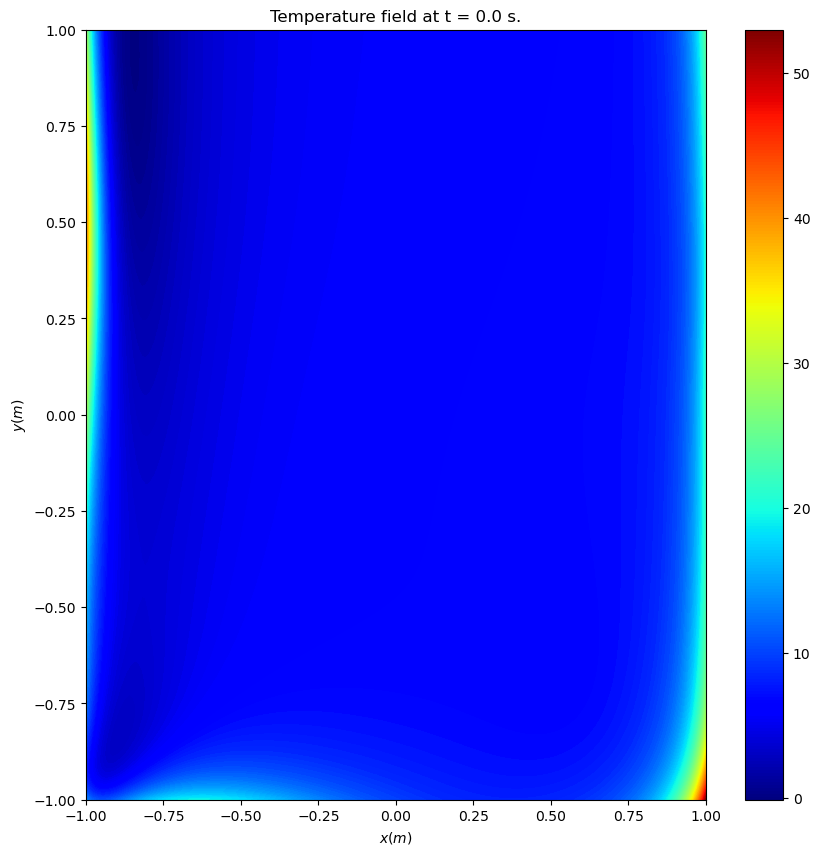

In [16]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import os

# x,y方向离散200个节点
x1 = np.linspace(-1,1,num=200,endpoint=True).flatten()
y1 = np.linspace(-1,1,num=200,endpoint=True).flatten()
xx1,yy1 = np.meshgrid(x1,y1)
x = xx1.flatten()
y = yy1.flatten()

# 时间上取20个时间步，时间步长1/20=0.05s
Nt = 20
dt = 1/Nt


for n in range(0, Nt+1):
    t = n * dt
    t_list = t*np.ones((len(x), 1))
    x_pred = np.concatenate([x[:, None], y[:, None], t_list], axis=1)
    y_pred = model.predict(x_pred)
    y_p = y_pred.flatten()
    data_n = np.concatenate([x_pred, y_pred], axis=1)
    if n == 0:
        data = data_n[:, :, None]
    else:
        data = np.concatenate([data, data_n[:, :, None]], axis=2)

print(x_pred.shape, y_pred.shape)
print(data.shape, data_n.shape)

# 创建图片保存路径
work_path = os.path.join('2DtransientRectTC',)
isCreated = os.path.exists(work_path)
if not isCreated:
    os.makedirs(work_path)
print("保存路径: " + work_path)

# 获得y的最大值和最小值
y_min = data.min(axis=(0,2,))[3]
y_max = data.max(axis=(0,2,))[3]
fig = plt.figure(100, figsize=(10, 10))

def anim_update(t_id):
    plt.clf()
    x1_t, x2_t, y_p_t = data[:, 0:1, t_id], data[:, 1:2, t_id], data[:, 3:4, t_id]
    x1_t, x2_t, y_p_t = x1_t.flatten(), x2_t.flatten(), y_p_t.flatten()
    print(t_id, x1_t.shape, x1_t.shape, y_p_t.shape)
    
    plt.subplot(1,1,1)
    plt.tricontourf(x1_t, x2_t, y_p_t, levels=160, cmap="jet")
    cb0 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=y_min, vmax=y_max), cmap="jet"),ax = plt.gca())  

    plt.xlabel('$x (m)$')
    plt.ylabel('$y (m)$')
    plt.title("Temperature field at t = " + str(round(t_id * dt,2)) + " s.", fontsize = 12) 
    plt.savefig(work_path + '//' + 'animation_' + str(t_id) + '.png')

print("data.shape[2] = ", data.shape[2])

# 创建动画
anim =FuncAnimation(fig, anim_update, frames=np.arange(0, data.shape[2]).astype(np.int64), interval=200)
anim.save(work_path + "//" + "animation-" + str(Nt+1) + ".gif", writer="pillow",dpi=300)

正常方法

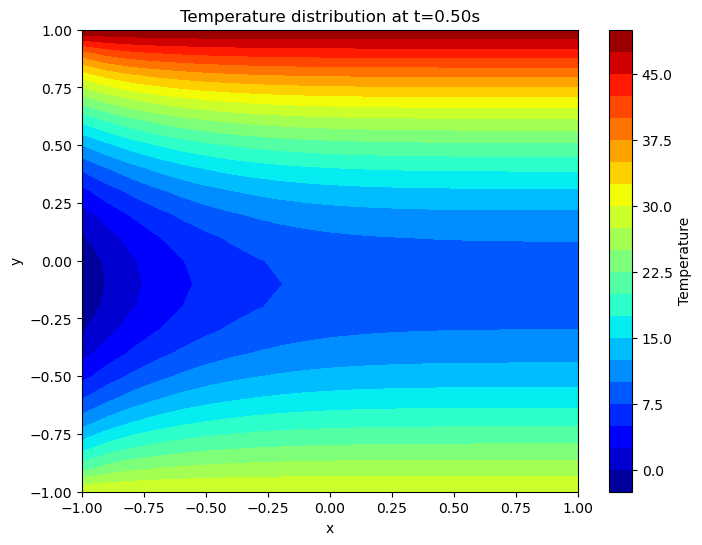

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
Lx, Ly = 2, 2  # 区域大小 [-1, 1] x [-1, 1]，边长为 2
Nx, Ny = 21, 21  # 空间离散点数
Nt = 500  # 时间步数
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # 空间步长
dt = 0.001  # 时间步长
alpha = 0.4  # 热扩散系数

# 创建网格
x = np.linspace(-1, 1, Nx)
y = np.linspace(-1, 1, Ny)
t = np.linspace(0, dt * Nt, Nt)
X, Y = np.meshgrid(x, y)

# 初始条件
T = np.zeros((Ny, Nx))  # T(x, y, t=0) = 0

# 边界条件函数
def apply_boundary_conditions(T):
    T[0, :] = 30  # 左侧边界 T(-1, y, t) = 30
    T[-1, :] = 50  # 右侧边界 T(1, y, t) = 50
    T[1:-1, 0] = T[1:-1, 1] - 20 * dy  # 底部边界 \partial T / \partial y |_{y=-1} = 20
    T[1:-1, -1] = T[1:-1, -2]  # 顶部边界 \partial T / \partial y |_{y=1} = 0
    return T

# 显式有限差分法求解
T_new = T.copy()
for n in range(1, Nt):
    T_new[1:-1, 1:-1] = (
        T[1:-1, 1:-1]
        + alpha * dt * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
            + (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )
    )
    T = apply_boundary_conditions(T_new)

# 绘制结果
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, T, 20, cmap="jet")
plt.colorbar(label="Temperature")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Temperature distribution at t={dt * Nt:.2f}s")
plt.show()

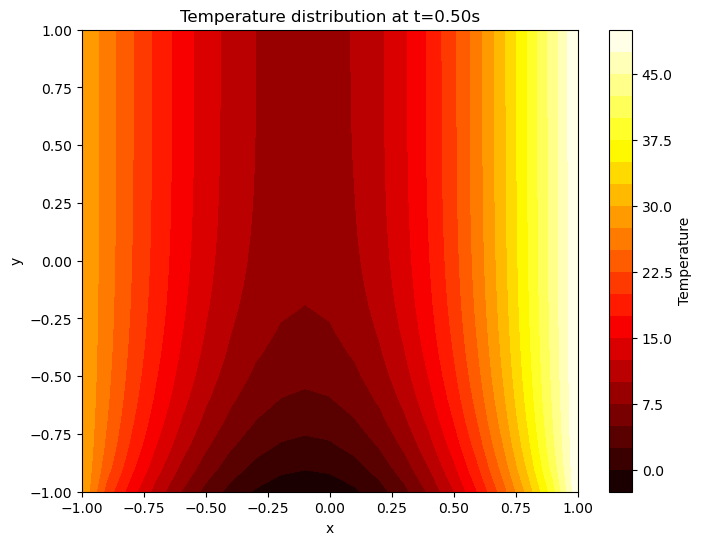

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
Lx, Ly = 2, 2  # 区域大小 [-1, 1] x [-1, 1]，边长为 2
Nx, Ny = 21, 21  # 空间离散点数
Nt = 500  # 时间步数
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # 空间步长
dt = 0.001  # 时间步长
alpha = 0.4  # 热扩散系数

# 创建网格
x = np.linspace(-1, 1, Nx)
y = np.linspace(-1, 1, Ny)
t = np.linspace(0, dt * Nt, Nt)
X, Y = np.meshgrid(y, x, indexing='ij')  # 调整网格生成顺序，确保与绘图一致

# 初始条件
T = np.zeros((Ny, Nx))  # T(x, y, t=0) = 0

# 边界条件函数
def apply_boundary_conditions(T):
    T[0, :] = 30  # 左侧边界 T(-1, y, t) = 30
    T[-1, :] = 50  # 右侧边界 T(1, y, t) = 50
    T[1:-1, 0] = T[1:-1, 1] - 20 * dy  # 底部边界 \partial T / \partial y |_{y=-1} = 20
    T[1:-1, -1] = T[1:-1, -2]  # 顶部边界 \partial T / \partial y |_{y=1} = 0
    return T

# 显式有限差分法求解
T_new = T.copy()
for n in range(1, Nt):
    T_new[1:-1, 1:-1] = (
        T[1:-1, 1:-1]
        + alpha * dt * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
            + (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )
    )
    T = apply_boundary_conditions(T_new)

# 绘制结果
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, T, 20, cmap="hot")
plt.colorbar(label="Temperature")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Temperature distribution at t={dt * Nt:.2f}s")
plt.show()


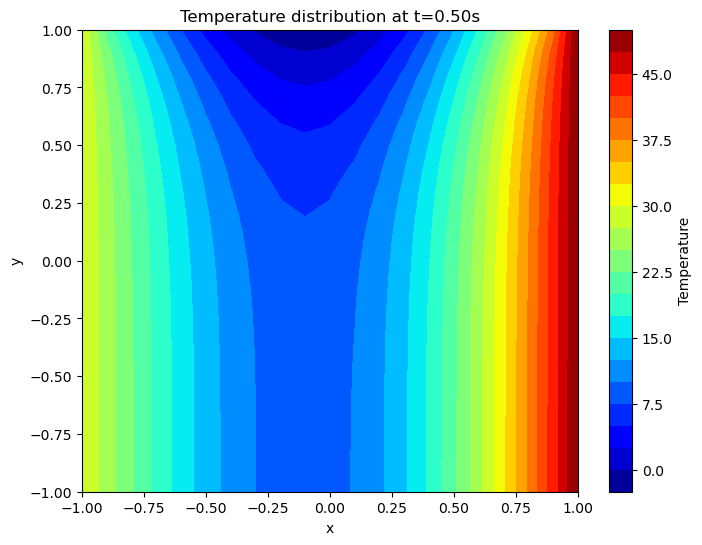

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
Lx, Ly = 2, 2  # 区域大小 [-1, 1] x [-1, 1]，边长为 2
Nx, Ny = 21, 21  # 空间离散点数
Nt = 500  # 时间步数
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # 空间步长
dt = 0.001  # 时间步长
alpha = 0.4  # 热扩散系数

# 创建网格
x = np.linspace(-1, 1, Nx)
y = np.linspace(-1, 1, Ny)
t = np.linspace(0, dt * Nt, Nt)
X, Y = np.meshgrid(x, y)

# 初始条件
T = np.zeros((Ny, Nx))  # T(x, y, t=0) = 0

# 边界条件函数
def apply_boundary_conditions(T):
    T[0, :] = 30  # 左侧边界 T(-1, y, t) = 30
    T[-1, :] = 50  # 右侧边界 T(1, y, t) = 50
    T[1:-1, 0] = T[1:-1, 1] - 20 * dy  # 底部边界 \partial T / \partial y |_{y=-1} = 20
    T[1:-1, -1] = T[1:-1, -2]  # 顶部边界 \partial T / \partial y |_{y=1} = 0
    return T

# 显式有限差分法求解
T_new = T.copy()
for n in range(1, Nt):
    T_new[1:-1, 1:-1] = (
        T[1:-1, 1:-1]
        + alpha * dt * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
            + (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )
    )
    T = apply_boundary_conditions(T_new)

# 旋转温度矩阵 T 90 度
T_rotated = np.rot90(T)

# 绘制结果
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, T_rotated, 20, cmap="jet")  # 使用旋转后的温度矩阵绘制
plt.colorbar(label="Temperature")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Temperature distribution at t={dt * Nt:.2f}s")
plt.show()


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import shutil

# 参数设置
Lx, Ly = 2, 2  # 区域大小 [-1, 1] x [-1, 1]，边长为 2
Nx, Ny = 21, 21  # 空间离散点数
Nt = 1000  # 时间步数
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # 空间步长
dt = 0.001  # 时间步长
alpha = 0.4  # 热扩散系数

# 创建网格
x = np.linspace(-1, 1, Nx)
y = np.linspace(-1, 1, Ny)
t = np.linspace(0, dt * Nt, Nt)
X, Y = np.meshgrid(x, y)

# 初始条件
T = np.zeros((Ny, Nx))  # T(x, y, t=0) = 0

# 边界条件函数
def apply_boundary_conditions(T):
    T[0, :] = 30  # 左侧边界 T(-1, y, t) = 30
    T[-1, :] = 50  # 右侧边界 T(1, y, t) = 50
    T[1:-1, 0] = T[1:-1, 1] - 20 * dy  # 底部边界 \partial T / \partial y |_{y=-1} = 20
    T[1:-1, -1] = T[1:-1, -2]  # 顶部边界 \partial T / \partial y |_{y=1} = 0
    return T

# 创建一个文件夹来保存图像
if not os.path.exists("frames"):
    os.makedirs("frames")

# 显式有限差分法求解并保存每一帧
# 从0到1秒，每0.05秒保存一个图像
frames_to_plot = np.arange(0, Nt, int(0.05 / dt))  # 每0.05秒一个图像
for n in frames_to_plot:
    T_new = T.copy()
    T_new[1:-1, 1:-1] = (
        T[1:-1, 1:-1]
        + alpha * dt * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
            + (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )
    )
    T = apply_boundary_conditions(T_new)

    # 每 50 个时间步保存一个帧
    T_rotated = np.rot90(T)
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, T_rotated, 20, cmap="jet")
    plt.colorbar(label="Temperature")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Temperature distribution at t={dt * n:.2f}s")
    plt.savefig(f"frames/frame_{n}.png")
    plt.close()

# 使用 imageio 将保存的帧合成动画
images = []
for n in frames_to_plot:  # 以相同的间隔加载图像
    images.append(imageio.imread(f"frames/frame_{n}.png"))

# 保存为 gif 动画
imageio.mimsave('temperature_distribution.gif', images, duration=0.1)  # 每帧之间 0.1 秒

# 如果你想保存为 mp4，可以使用下面的代码
# imageio.mimsave('temperature_distribution.mp4', images, fps=30)

# 清理保存的图像帧
shutil.rmtree('frames')

print("动画保存成功！")


/tmp/ipykernel_1419326/1257219028.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"frames/frame_{n}.png"))


动画保存成功！


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

# 参数设置
Lx, Ly = 2, 2  # 区域大小 [-1, 1] x [-1, 1]，边长为 2
Nx, Ny = 21, 21  # 空间离散点数
Nt = 1000  # 时间步数
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # 空间步长
dt = 0.001  # 时间步长
alpha = 0.4  # 热扩散系数

# 创建网格
x = np.linspace(-1, 1, Nx)
y = np.linspace(-1, 1, Ny)
t = np.linspace(0, dt * Nt, Nt)
X, Y = np.meshgrid(x, y)

# 初始条件
T = np.zeros((Ny, Nx))  # T(x, y, t=0) = 0

# 边界条件函数
def apply_boundary_conditions(T):
    T[0, :] = 30  # 左侧边界 T(-1, y, t) = 30
    T[-1, :] = 50  # 右侧边界 T(1, y, t) = 50
    T[1:-1, 0] = T[1:-1, 1] - 20 * dy  # 底部边界 \partial T / \partial y |_{y=-1} = 20
    T[1:-1, -1] = T[1:-1, -2]  # 顶部边界 \partial T / \partial y |_{y=1} = 0
    return T

# 创建一个文件夹来保存图像
output_folder = "output_frames"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 显式有限差分法求解并保存每一帧
# 从0到1秒，每0.05秒保存一个图像
frames_to_plot = np.arange(0, Nt, int(0.05 / dt))  # 每0.05秒一个图像
for n in frames_to_plot:
    T_new = T.copy()
    T_new[1:-1, 1:-1] = (
        T[1:-1, 1:-1]
        + alpha * dt * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
            + (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )
    )
    T = apply_boundary_conditions(T_new)

    # 每 50 个时间步保存一个帧
    T_rotated = np.rot90(T)
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, T_rotated, 20, cmap="jet")
    plt.colorbar(label="Temperature")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Temperature distribution at t={dt * n:.2f}s")
    plt.savefig(f"{output_folder}/frame_{n}.png")
    plt.close()

# 使用 imageio 将保存的帧合成动画
images = []
for n in frames_to_plot:  # 以相同的间隔加载图像
    images.append(imageio.imread(f"{output_folder}/frame_{n}.png"))

# 保存为 gif 动画
imageio.mimsave('temperature_distribution.gif', images, duration=0.1)  # 每帧之间 0.1 秒

# 如果需要清理帧文件夹，可以手动选择是否删除
print(f"动画保存成功！所有帧图像已存储在文件夹：{output_folder}")


/tmp/ipykernel_1419326/766675418.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"{output_folder}/frame_{n}.png"))


动画保存成功！所有帧图像已存储在文件夹：output_frames


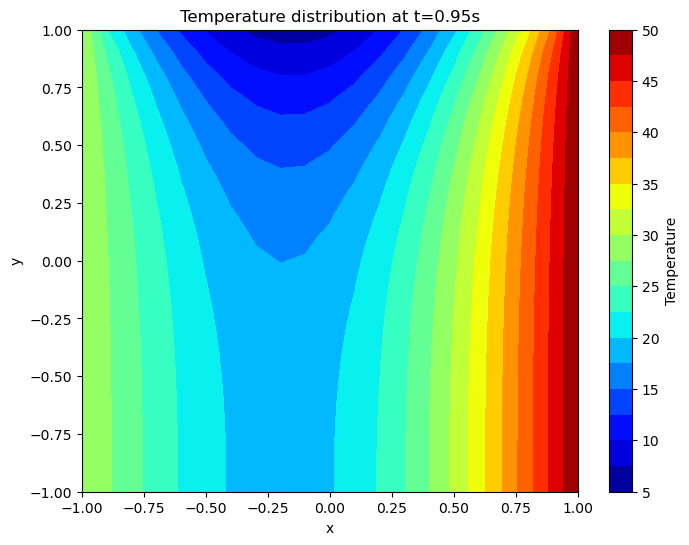

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
Lx, Ly = 2, 2  # 区域大小 [-1, 1] x [-1, 1]，边长为 2
Nx, Ny = 21, 21  # 空间离散点数
dt = 0.001  # 时间步长
alpha = 0.4  # 热扩散系数

# 修改时间范围到 t=0.9s
Nt = int(0.95 / dt)  # t=0.9s 对应的时间步数

# 创建网格
x = np.linspace(-1, 1, Nx)
y = np.linspace(-1, 1, Ny)
t = np.linspace(0, dt * Nt, Nt)
X, Y = np.meshgrid(x, y)

# 初始条件
T = np.zeros((Ny, Nx))  # T(x, y, t=0) = 0

# 边界条件函数
def apply_boundary_conditions(T):
    T[0, :] = 30  # 左侧边界 T(-1, y, t) = 30
    T[-1, :] = 50  # 右侧边界 T(1, y, t) = 50
    T[1:-1, 0] = T[1:-1, 1] - 20 * dy  # 底部边界 \partial T / \partial y |_{y=-1} = 20
    T[1:-1, -1] = T[1:-1, -2]  # 顶部边界 \partial T / \partial y |_{y=1} = 0
    return T

# 显式有限差分法求解
T_new = T.copy()
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # 空间步长

for n in range(1, Nt):
    T_new[1:-1, 1:-1] = (
        T[1:-1, 1:-1]
        + alpha * dt * (
            (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2
            + (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
        )
    )
    T = apply_boundary_conditions(T_new)

# 旋转温度矩阵 T 90 度
T_rotated = np.rot90(T)

# 绘制结果
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, T_rotated, 20, cmap="jet")  # 使用旋转后的温度矩阵绘制
plt.colorbar(label="Temperature")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Temperature distribution at t={dt * Nt:.2f}s")
plt.show()


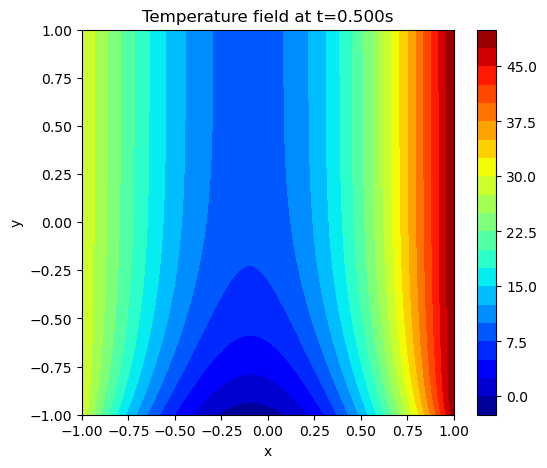

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
alpha = 0.4
Lx = 2.0
Ly = 2.0
Nx = 51
Ny = 51
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

x = np.linspace(-1,1,Nx)
y = np.linspace(-1,1,Ny)

# 时间步设置（显式格式下稳定性要求严格）
# 简易稳定性条件：dt < min(dx^2, dy^2)/(4*alpha)
dt = min(dx**2, dy**2)/(4*alpha)
t_target = 0.5
Nt = int(t_target/dt)  # 与0.5s最接近的步数

# 初始场
T = np.zeros((Nx, Ny))
T_new = np.zeros((Nx, Ny))

T_left = 30.0
T_right = 50.0

for n in range(Nt):
    # Dirichlet边界条件(左右)
    T[0,:] = T_left
    T[-1,:] = T_right
    
    # Neumann边界条件(上下)
    T[:,0] = T[:,1] - 20*dy   # bottom: dT/dy=20 => T(i,0)=T(i,1)-20*dy
    T[:,Ny-1] = T[:,Ny-2]     # top: dT/dy=0 => T(i,Ny-1)=T(i,Ny-2)
    
    # 显式迭代内部点更新
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            d2Tdx2 = (T[i+1,j] - 2*T[i,j] + T[i-1,j]) / dx**2
            d2Tdy2 = (T[i,j+1] - 2*T[i,j] + T[i,j-1]) / dy**2
            T_new[i,j] = T[i,j] + alpha*dt*(d2Tdx2 + d2Tdy2)
    
    # 更新边界到T_new中
    T_new[0,:] = T_left
    T_new[-1,:] = T_right
    T_new[:,0] = T_new[:,1] - 20*dy
    T_new[:,Ny-1] = T_new[:,Ny-2]
    
    # 交换指针
    T, T_new = T_new, T

# 走到这里，T即为t接近0.5 s时的温度场分布
X, Y = np.meshgrid(x, y, indexing='ij')
plt.figure(figsize=(6,5))
cp = plt.contourf(X, Y, T, 20, cmap='jet')
plt.colorbar(cp)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature field at t={:.3f}s'.format(Nt*dt))
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
/tmp/ipykernel_1419326/4162222021.py:75: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return cp.collections


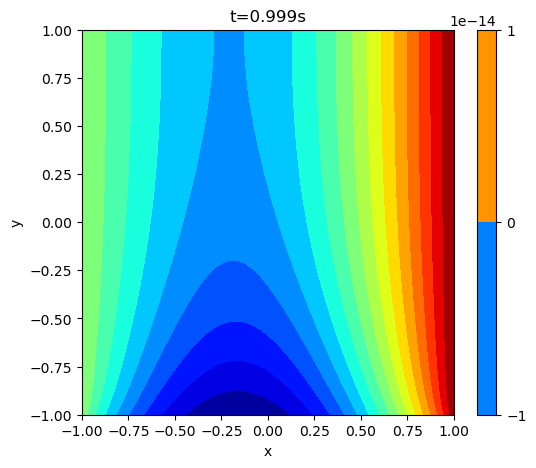

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 参数设置
alpha = 0.4
Lx = 2.0
Ly = 2.0
Nx = 51
Ny = 51
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

x = np.linspace(-1,1,Nx)
y = np.linspace(-1,1,Ny)

# 时间相关参数
dt = min(dx**2, dy**2)/(4*alpha)  # 稳定性限制
t_final = 1.0
Nt = int(t_final/dt)

# 初始场
T = np.zeros((Nx, Ny))
T_new = np.zeros((Nx, Ny))

T_left = 30.0
T_right = 50.0

# 准备绘图
fig, ax = plt.subplots(figsize=(6,5))
X, Y = np.meshgrid(x, y, indexing='ij')
cp = ax.contourf(X, Y, T, 20, cmap='jet')
cbar = plt.colorbar(cp, ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
title = ax.set_title('t=0.000 s')

# 更新函数，每次调用此函数计算一个时间步并更新图像
def update(frame):
    global T, T_new
    # frame是当前的时间步索引，从0开始
    # 应用Dirichlet边界条件(左右)
    T[0,:] = T_left
    T[-1,:] = T_right
    
    # 应用Neumann边界条件(上下)
    T[:,0] = T[:,1] - 20*dy   # bottom: dT/dy=20
    T[:,Ny-1] = T[:,Ny-2]     # top: dT/dy=0
    
    # 显式迭代更新内部点
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            d2Tdx2 = (T[i+1,j] - 2*T[i,j] + T[i-1,j]) / dx**2
            d2Tdy2 = (T[i,j+1] - 2*T[i,j] + T[i,j-1]) / dy**2
            T_new[i,j] = T[i,j] + alpha*dt*(d2Tdx2 + d2Tdy2)
    
    # 更新边界到T_new中（防止数值扩散边界被改动）
    T_new[0,:] = T_left
    T_new[-1,:] = T_right
    T_new[:,0] = T_new[:,1] - 20*dy
    T_new[:,Ny-1] = T_new[:,Ny-2]
    
    # 交换T和T_new
    T, T_new = T_new, T
    
    # 更新绘图
    # 先清除上一帧的contourf，然后重新绘制
    ax.clear()
    cp = ax.contourf(X, Y, T, 20, cmap='jet')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    current_time = frame*dt
    ax.set_title(f't={current_time:.3f}s')
    
    return cp.collections

anim = FuncAnimation(fig, update, frames=Nt, interval=50, blit=False)

# 如果需要保存动画，请确保安装了ffmpeg或imagemagick
anim.save('heat_distribution.gif', writer='imagemagick', fps=20)

plt.show()
